# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

In [2]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.3.1'

#### Load Image Data

In [3]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


/Users/gil/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, Conv2D, MaxPool2D, Flatten

In [6]:
vggmodel = tf.keras.applications.vgg16.VGG16(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)  
vggmodel.trainable = False

In [7]:
type(vggmodel)

tensorflow.python.keras.engine.functional.Functional

In [8]:
model = Sequential(
    [
        vggmodel,
        Flatten(),
        Dense(units = 256,activation='relu', name = 'feature_dense'),
        Dense(units = 4, activation = 'softmax', name = 'dense_1')
    ]
)

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer = opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
feature_dense (Dense)        (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 21,138,500
Trainable params: 6,423,812
Non-trainable params: 14,714,688
_________________________________________________________________


In [11]:
# AlexNet
alexnet = Sequential(
    [
        #Layer 1
        Conv2D(filters=96, input_shape=(224,224,3),kernel_size=(11,11), strides=(4,4), padding='valid', activation='relu'),
        MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'),
        #Layer 2
        Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid', activation='relu'),
        MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'),
        #Layer 3
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'),
        #Layer 4
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'),
        #Layer 5
        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'),
        MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'),
        #FC Layer 1
        Flatten(),
        Dense(256, activation='relu', name='feature_dense'),
        #Dropout
        Dropout(.4),
        #FC Layer 2
        Dense(4096, activation = 'relu'),
        Dropout(.4),
        #FC Layer 3
        Dense(1000, activation = 'relu'),
        Dropout(.4),
        #Output
        Dense(4, activation='softmax')
    ]
)

In [12]:
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 256)       2973952   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 384)         885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 384)         1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 256)        

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
alexnet.compile(optimizer = opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [14]:
#ResNet50

In [15]:
resnet50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# resnet50.trainable = False
resnet = Sequential(
    [
        resnet50,
        Flatten(),
        Dense(256, name='feature_dense', activation='relu'),
        Dropout(.25),
        Dense(4, activation='softmax')
    ]
)
resnet.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
feature_dense (Dense)        (None, 256)               25690368  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 49,279,108
Trainable params: 49,225,988
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
resnet.compile(optimizer = opt, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [17]:
#raise NotImplementedError("Build your model based on an architecture of your choice "
                        #  "A sample model summary is shown below")

#### [5 points] Train Model

In [18]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

#raise NotImplementedError("Use the model.fit function to train your network")

22
6


In [19]:
history = model.fit_generator(steps_per_epoch = STEP_SIZE_TRAIN, generator = train_batches, validation_data = valid_batches, validation_steps = STEP_SIZE_VALID, epochs = NUM_EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.


/Users/gil/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/gil/opt/anaconda3/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
21/21 [==============================] - 57s 3s/step - loss: 0.5689 - accuracy: 0.3155 - val_loss: 0.5568 - val_accuracy: 0.4000
Epoch 2/100
21/21 [==============================] - 59s 3s/step - loss: 0.4881 - accuracy: 0.4903 - val_loss: 0.4646 - val_accuracy: 0.4800
Epoch 3/100
21/21 [==============================] - 52s 2s/step - loss: 0.4471 - accuracy: 0.5000 - val_loss: 0.4291 - val_accuracy: 0.6000
Epoch 4/100
21/21 [==============================] - 53s 3s/step - loss: 0.4319 - accuracy: 0.5291 - val_loss: 0.3915 - val_accuracy: 0.6600
Epoch 5/100
21/21 [==============================] - 53s 3s/step - loss: 0.4069 - accuracy: 0.5534 - val_loss: 0.3635 - val_accuracy: 0.7200
Epoch 6/100
21/21 [==============================] - 55s 3s/step - loss: 0.4031 - accuracy: 0.5777 - val_loss: 0.4170 - val_accuracy: 0.5200
Epoch 7/100
21/21 [==============================] - 54s 3s/step - loss: 0.4112 - accuracy: 0.5680 - val_loss: 0.3839 - val_accuracy: 0.6200
Epoch 8/100
2

Epoch 59/100
21/21 [==============================] - 57s 3s/step - loss: 0.2335 - accuracy: 0.7476 - val_loss: 0.3359 - val_accuracy: 0.6200
Epoch 60/100
21/21 [==============================] - 57s 3s/step - loss: 0.2199 - accuracy: 0.8398 - val_loss: 0.2935 - val_accuracy: 0.6800
Epoch 61/100
21/21 [==============================] - 57s 3s/step - loss: 0.2392 - accuracy: 0.7864 - val_loss: 0.2848 - val_accuracy: 0.7200
Epoch 62/100
21/21 [==============================] - 58s 3s/step - loss: 0.2292 - accuracy: 0.7952 - val_loss: 0.3723 - val_accuracy: 0.6200
Epoch 63/100
21/21 [==============================] - 57s 3s/step - loss: 0.2544 - accuracy: 0.7718 - val_loss: 0.4002 - val_accuracy: 0.5400
Epoch 64/100
21/21 [==============================] - 58s 3s/step - loss: 0.2461 - accuracy: 0.7961 - val_loss: 0.2170 - val_accuracy: 0.7600
Epoch 65/100
21/21 [==============================] - 58s 3s/step - loss: 0.2200 - accuracy: 0.7621 - val_loss: 0.3216 - val_accuracy: 0.7200
Epoch 

In [20]:
alexnet_history=alexnet.fit_generator(steps_per_epoch = STEP_SIZE_TRAIN, generator = train_batches, validation_data = valid_batches, validation_steps = STEP_SIZE_VALID, epochs = NUM_EPOCHS)

Epoch 1/100
21/21 [==============================] - 15s 721ms/step - loss: 1.3910 - accuracy: 0.2670 - val_loss: 1.3842 - val_accuracy: 0.2600
Epoch 2/100
21/21 [==============================] - 15s 713ms/step - loss: 1.3861 - accuracy: 0.2670 - val_loss: 1.3859 - val_accuracy: 0.2400
Epoch 3/100
21/21 [==============================] - 15s 703ms/step - loss: 1.3847 - accuracy: 0.2718 - val_loss: 1.3859 - val_accuracy: 0.2600
Epoch 4/100
21/21 [==============================] - 15s 707ms/step - loss: 1.3859 - accuracy: 0.2330 - val_loss: 1.3856 - val_accuracy: 0.2600
Epoch 5/100
21/21 [==============================] - 15s 702ms/step - loss: 1.3859 - accuracy: 0.2524 - val_loss: 1.3841 - val_accuracy: 0.2800
Epoch 6/100
21/21 [==============================] - 15s 715ms/step - loss: 1.3888 - accuracy: 0.2233 - val_loss: 1.3849 - val_accuracy: 0.2800
Epoch 7/100
21/21 [==============================] - 15s 706ms/step - loss: 1.3863 - accuracy: 0.2476 - val_loss: 1.3858 - val_accuracy:

21/21 [==============================] - 15s 701ms/step - loss: 1.3856 - accuracy: 0.2427 - val_loss: 1.3815 - val_accuracy: 0.2800
Epoch 58/100
21/21 [==============================] - 15s 716ms/step - loss: 1.3847 - accuracy: 0.2476 - val_loss: 1.3815 - val_accuracy: 0.2800
Epoch 59/100
21/21 [==============================] - 15s 706ms/step - loss: 1.3851 - accuracy: 0.2476 - val_loss: 1.3826 - val_accuracy: 0.2800
Epoch 60/100
21/21 [==============================] - 15s 710ms/step - loss: 1.3837 - accuracy: 0.2767 - val_loss: 1.3868 - val_accuracy: 0.2600
Epoch 61/100
21/21 [==============================] - 15s 712ms/step - loss: 1.3858 - accuracy: 0.2282 - val_loss: 1.3864 - val_accuracy: 0.2600
Epoch 62/100
21/21 [==============================] - 15s 700ms/step - loss: 1.3830 - accuracy: 0.2427 - val_loss: 1.3867 - val_accuracy: 0.2600
Epoch 63/100
21/21 [==============================] - 15s 713ms/step - loss: 1.3851 - accuracy: 0.2476 - val_loss: 1.3867 - val_accuracy: 0.260

In [21]:
resnet_history=resnet.fit_generator(steps_per_epoch = STEP_SIZE_TRAIN, generator = train_batches, validation_data = valid_batches, validation_steps = STEP_SIZE_VALID, epochs = NUM_EPOCHS)

Epoch 1/100
21/21 [==============================] - 72s 3s/step - loss: 3.2278 - accuracy: 0.4143 - val_loss: 2.1788 - val_accuracy: 0.3200
Epoch 2/100
21/21 [==============================] - 70s 3s/step - loss: 1.6920 - accuracy: 0.6456 - val_loss: 2.0981 - val_accuracy: 0.2400
Epoch 3/100
21/21 [==============================] - 70s 3s/step - loss: 1.0839 - accuracy: 0.6650 - val_loss: 4.1386 - val_accuracy: 0.2600
Epoch 4/100
21/21 [==============================] - 71s 3s/step - loss: 0.9419 - accuracy: 0.6796 - val_loss: 1.7880 - val_accuracy: 0.2000
Epoch 5/100
21/21 [==============================] - 71s 3s/step - loss: 0.8164 - accuracy: 0.6796 - val_loss: 1.6011 - val_accuracy: 0.2000
Epoch 6/100
21/21 [==============================] - 71s 3s/step - loss: 0.7088 - accuracy: 0.7039 - val_loss: 1.7251 - val_accuracy: 0.3000
Epoch 7/100
21/21 [==============================] - 71s 3s/step - loss: 0.6652 - accuracy: 0.7282 - val_loss: 1.9326 - val_accuracy: 0.2600
Epoch 8/100
2

Epoch 59/100
21/21 [==============================] - 78s 4s/step - loss: 0.2435 - accuracy: 0.8981 - val_loss: 0.8854 - val_accuracy: 0.6600
Epoch 60/100
21/21 [==============================] - 87s 4s/step - loss: 0.3648 - accuracy: 0.8592 - val_loss: 2.4038 - val_accuracy: 0.5000
Epoch 61/100
21/21 [==============================] - 86s 4s/step - loss: 0.4837 - accuracy: 0.8835 - val_loss: 2.3735 - val_accuracy: 0.5200
Epoch 62/100
21/21 [==============================] - 82s 4s/step - loss: 0.2782 - accuracy: 0.8883 - val_loss: 1.4629 - val_accuracy: 0.4800
Epoch 63/100
21/21 [==============================] - 79s 4s/step - loss: 0.3163 - accuracy: 0.8738 - val_loss: 1.4205 - val_accuracy: 0.5800
Epoch 64/100
21/21 [==============================] - 80s 4s/step - loss: 0.3088 - accuracy: 0.8738 - val_loss: 1.5243 - val_accuracy: 0.6000
Epoch 65/100
21/21 [==============================] - 93s 4s/step - loss: 0.2552 - accuracy: 0.8932 - val_loss: 0.5542 - val_accuracy: 0.7600
Epoch 

#### [5 points] Plot Accuracy and Loss During Training

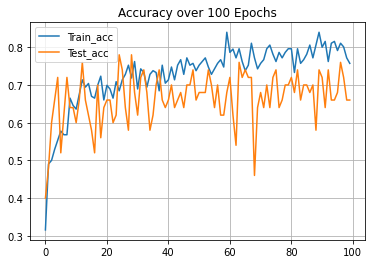

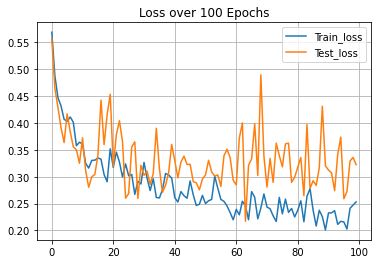

In [22]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy over 100 Epochs')
plt.legend(['Train_acc', 'Test_acc'], loc=2)
plt.grid(True)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over 100 Epochs')
plt.legend(['Train_loss', 'Test_loss'], loc=1)
plt.grid(True)
plt.show()

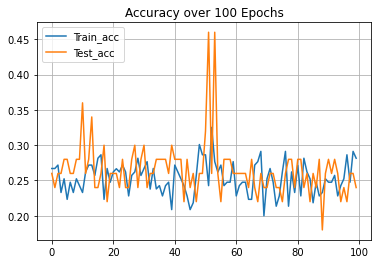

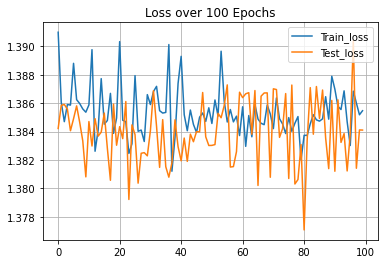

In [23]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(alexnet_history.history['accuracy'])
plt.plot(alexnet_history.history['val_accuracy'])
plt.title('Accuracy over 100 Epochs')
plt.legend(['Train_acc', 'Test_acc'], loc=2)
plt.grid(True)
plt.show()

# summarize history for loss
plt.plot(alexnet_history.history['loss'])
plt.plot(alexnet_history.history['val_loss'])
plt.title('Loss over 100 Epochs')
plt.legend(['Train_loss', 'Test_loss'], loc=1)
plt.grid(True)
plt.show()

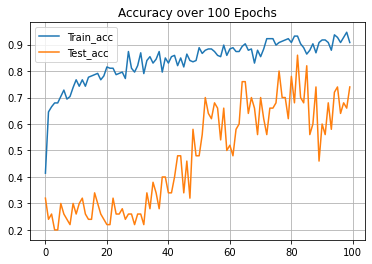

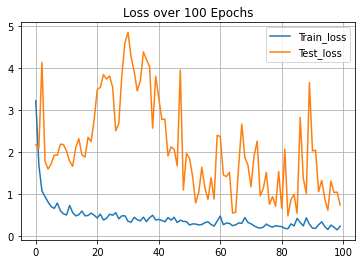

In [24]:
# summarize history for accuracy
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Accuracy over 100 Epochs')
plt.legend(['Train_acc', 'Test_acc'], loc=2)
plt.grid(True)
plt.show()

# summarize history for loss
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('Loss over 100 Epochs')
plt.legend(['Train_loss', 'Test_loss'], loc=1)
plt.grid(True)
plt.show()

#### Testing Model

In [25]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
Instructions for updating:
Please use Model.evaluate, which supports generators.
36/36 [==============================] - 8s 215ms/step - loss: 0.3709 - accuracy: 0.6944
Test loss: 0.37092161178588867
Test accuracy: 0.6944444179534912


In [26]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = alexnet.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 1s 29ms/step - loss: 1.3880 - accuracy: 0.2500
Test loss: 1.3879629373550415
Test accuracy: 0.25


In [27]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = resnet.evaluate_generator(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 4s 100ms/step - loss: 1.8828 - accuracy: 0.5833
Test loss: 1.8827906847000122
Test accuracy: 0.5833333134651184


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

In [28]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('feature_dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")


Found 270 images belonging to 4 classes.


Found 270 images belonging to 4 classes.
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
Instructions for updating:
Please use Model.predict, which supports generators.
270/270 [==============================] - 61s 227ms/step


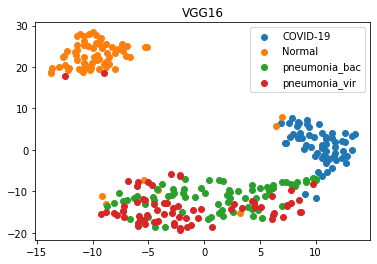

In [29]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=model.get_layer('feature_dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
tsne_eval_generator.reset()
labels = tsne_eval_generator.classes
print(tsne_eval_generator.class_indices)

X = intermediate_layer_model.predict_generator(tsne_eval_generator, verbose=1)
X_embedded = TSNE().fit_transform(X)

classes = ["COVID-19", "Normal", "pneumonia_bac", "pneumonia_vir"]
plt.title('VGG16')
for i in range(4):
    clusters = X_embedded[np.where(labels == i)]
    plt.scatter(clusters[:, 0], clusters[:, 1], label = classes[i])
plt.legend()

Found 270 images belonging to 4 classes.
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
270/270 [==============================] - 7s 25ms/step


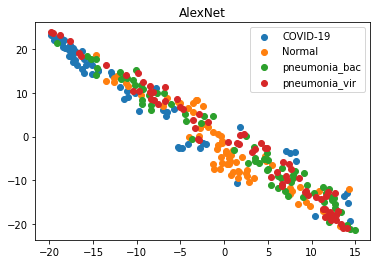

In [33]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=alexnet.input,
                                        outputs=alexnet.get_layer('feature_dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
tsne_eval_generator.reset()
labels = tsne_eval_generator.classes
print(tsne_eval_generator.class_indices)

X = intermediate_layer_model.predict_generator(tsne_eval_generator, verbose=1)
X_embedded = TSNE().fit_transform(X)

classes = ["COVID-19", "Normal", "pneumonia_bac", "pneumonia_vir"]
plt.title('AlexNet')
for i in range(4):
    clusters = X_embedded[np.where(labels == i)]
    plt.scatter(clusters[:, 0], clusters[:, 1], label = classes[i])
plt.legend()

Found 270 images belonging to 4 classes.
{'covid': 0, 'normal': 1, 'pneumonia_bac': 2, 'pneumonia_vir': 3}
270/270 [==============================] - 28s 103ms/step


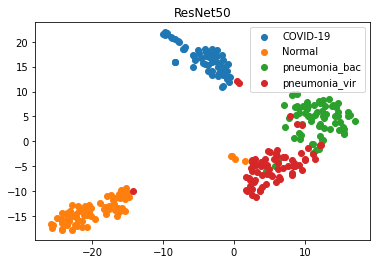

In [32]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=resnet.input,
                                        outputs=resnet.get_layer('feature_dense').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")
tsne_eval_generator.reset()
labels = tsne_eval_generator.classes
print(tsne_eval_generator.class_indices)

X = intermediate_layer_model.predict_generator(tsne_eval_generator, verbose=1)
X_embedded = TSNE().fit_transform(X)

classes = ["COVID-19", "Normal", "pneumonia_bac", "pneumonia_vir"]
plt.title('ResNet50')
for i in range(4):
    clusters = X_embedded[np.where(labels == i)]
    plt.scatter(clusters[:, 0], clusters[:, 1], label = classes[i])
plt.legend()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->